# IMPORTS

In [1]:
# general imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ast
from textblob import TextBlob  
from collections import Counter
import random
import torch
from sklearn.model_selection import train_test_split
import warnings

# import for utility
from src.utils.data_utils import *
from src.utils.evaluation_utils import *
from src.utils.general_utils import *

# import for models 
from src.models.sentiment_analysis import *
from src.models.crossvalidation import *
from src.models.neural_network import *

# SETTINGS

In [2]:
SETTINGS = {
    "DATA_RUTE": r"data/",
    "ORIGINAL_DATA_RUTE": r"data/original_data/",
    "DATA_VERSION": 3,
    
    "MODEL_SETTINGS":{
        "LAYER_SIZE": 128,
        "GENRE_THRESHOLD": 0.5,
        "TEST_SET": 0,
        "TEST_PROPORTION": 0.2,
        "SEED": 42,
    },
}

In [3]:
warnings.filterwarnings("ignore") #filter some warnings for better readability of the notebook

# DATA LOADING

In [4]:
# Load movie data
MOVIES = load_movie_data(SETTINGS)
MOVIES.head()

,wikipedia_movie_ID,name,release_date,revenue,runtime,languages,countries,genres,release_year,vote_average,vote_count,release_date_new,revenue_new,runtime_new,adult,budget,overview,popularity,release_year_new
0,975900,ghosts of mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001,5.127,977,2001-08-24,14010832,98,False,28000000,"In 2176, a Martian police unit is sent to pick...",14.189,2001
1,3196793,getting away with murder: the jonbenét ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",2000,0.0,0,2000-02-16,0,60,False,0,Dramatization of the story behind the murder o...,0.6,2000
2,13696889,the gangsters,1913-05-29,NaN,35.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",1913,6.0,1,1913-05-29,0,35,False,0,An amusing burlesque of gang fighters. The pol...,0.6,1913
3,10408933,alexander's ragtime band,1938-08-16,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ...",1938,6.6,23,1938-05-24,4000000,106,False,2000000,"Classical violinist, Roger Grant disappoints h...",2.522,1938
4,2345652,city of the dead,1960,NaN,76.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/03npn"": ""Horror"", ""/m/0fdjb"": ""Supernatur...",0,0.0,0,NaN,0,77,False,0,This is vintage horror stuff. A sleepy northea...,0.6,0


In [5]:
# Load character data
CHARACTER = load_character_data(SETTINGS)
CHARACTER.head()

,Wikipedia movie ID,Freebase movie ID,Movie release date,Character name,Actor date of birth,Actor gender,Actor height (in meters),Actor ethnicity (Freebase ID),Actor name,Actor age at movie release,Freebase character/actor map ID,Freebase character ID,Freebase actor ID
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


In [6]:
# Merge movie df with plots
MOVIES = merge_plot_movies(SETTINGS, MOVIES)
MOVIES.head()

,wikipedia_movie_ID,name,release_date,revenue,runtime,languages,countries,genres,release_year,vote_average,vote_count,release_date_new,revenue_new,runtime_new,adult,budget,overview,popularity,release_year_new,plot
0,975900,ghosts of mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001,5.127,977,2001-08-24,14010832,98,False,28000000,"In 2176, a Martian police unit is sent to pick...",14.189,2001,"Set in the second half of the 22nd century, th..."
1,3196793,getting away with murder: the jonbenét ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",2000,0.0,0,2000-02-16,0,60,False,0,Dramatization of the story behind the murder o...,0.6,2000,NaN
2,13696889,the gangsters,1913-05-29,NaN,35.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",1913,6.0,1,1913-05-29,0,35,False,0,An amusing burlesque of gang fighters. The pol...,0.6,1913,NaN
3,10408933,alexander's ragtime band,1938-08-16,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ...",1938,6.6,23,1938-05-24,4000000,106,False,2000000,"Classical violinist, Roger Grant disappoints h...",2.522,1938,NaN
4,2345652,city of the dead,1960,NaN,76.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/03npn"": ""Horror"", ""/m/0fdjb"": ""Supernatur...",0,0.0,0,NaN,0,77,False,0,This is vintage horror stuff. A sleepy northea...,0.6,0,NaN


In [7]:
MOVIES.columns

Index(['wikipedia_movie_ID', 'name', 'release_date', 'revenue', 'runtime',
       'languages', 'countries', 'genres', 'release_year', 'vote_average',
       'vote_count', 'release_date_new', 'revenue_new', 'runtime_new', 'adult',
       'budget', 'overview', 'popularity', 'release_year_new', 'plot'],
      dtype='object')

### Duplicated columns

In [8]:
len(MOVIES["wikipedia_movie_ID"]) - len(MOVIES["wikipedia_movie_ID"].unique())

6023

In [9]:
MOVIES[MOVIES.duplicated(subset=['wikipedia_movie_ID'], keep=False)].sort_values(by="wikipedia_movie_ID", ascending=False).head()

,wikipedia_movie_ID,name,release_date,revenue,runtime,languages,countries,genres,release_year,vote_average,vote_count,release_date_new,revenue_new,runtime_new,adult,budget,overview,popularity,release_year_new,plot
3039,37283373,island,NaN,NaN,NaN,"{""/m/02h40lc"": ""English Language""}",{},"{""/m/01drsx"": ""Disaster""}",0,0.0,0,NaN,0,4,False,0,"An immigrant in Italy, away from his family wh...",0.6,0,A Czech-born woman arrives on a Greek island h...
3040,37283373,island,NaN,NaN,NaN,"{""/m/02h40lc"": ""English Language""}",{},"{""/m/01drsx"": ""Disaster""}",0,0.0,0,NaN,0,0,False,0,A maritime warden investigates an unauthorised...,0.6,0,A Czech-born woman arrives on a Greek island h...
3035,37283373,island,NaN,NaN,NaN,"{""/m/02h40lc"": ""English Language""}",{},"{""/m/01drsx"": ""Disaster""}",0,0.0,0,NaN,0,0,False,0,A man lost at sea washes up on an island.,0.6,0,A Czech-born woman arrives on a Greek island h...
3036,37283373,island,NaN,NaN,NaN,"{""/m/02h40lc"": ""English Language""}",{},"{""/m/01drsx"": ""Disaster""}",0,0.0,0,NaN,0,13,False,0,a short film by,0.6,0,A Czech-born woman arrives on a Greek island h...
3037,37283373,island,NaN,NaN,NaN,"{""/m/02h40lc"": ""English Language""}",{},"{""/m/01drsx"": ""Disaster""}",0,0.0,0,NaN,0,4,False,0,"A music video by Eli Hayes for Geomi’s track, ...",0.0,0,A Czech-born woman arrives on a Greek island h...


In [10]:
MOVIES.isna().sum()

wikipedia_movie_ID        0
name                      0
release_date           1503
revenue               33109
runtime                6809
languages                 0
countries                 0
genres                    0
release_year              0
vote_average              0
vote_count                0
release_date_new       9951
revenue_new               0
runtime_new               0
adult                     0
budget                    0
overview               2508
popularity                0
release_year_new          0
plot                  15879
dtype: int64

As we can see there are some missing values and duplicated movies...
Lets do some ✨magic✨
### Remove duplicates

In [11]:
MOVIES = remove_duplicate_movies(MOVIES)
len(MOVIES)-len(MOVIES["wikipedia_movie_ID"].unique()) #number of duplicates


0

# DATA WRANGLING

- NANs
- Non-sense values
- Gather sub-genre into general genre
- 
  ...

### Recover information from the new dataset if it was missing in the original

In [12]:
MOVIES = recover_from_new_db(MOVIES)

### Release date to year

In [13]:
FIRST_MOVIE_YEAR = 1888
ACTUAL_YEAR = 2024

MOVIES = clean_release_year(MOVIES)
print(f'Fist year: {MOVIES["release_year"].min()}, Last year: {MOVIES["release_year"].max()}')
MOVIES["release_year"]

Fist year: 1894.0, Last year: 2016.0


0        2001.0
1        2000.0
2        1913.0
3        1938.0
5        1997.0
          ...  
33938    1976.0
33939    1960.0
33941    1992.0
33942    1976.0
33943    1989.0
Name: release_year, Length: 29447, dtype: float64

### Parse features to actual numbers

In [14]:
MOVIES = parse_features(MOVIES)
MOVIES.head()

,wikipedia_movie_ID,name,release_date,revenue,runtime,languages,countries,genres,release_year,vote_average,...,release_date_new,revenue_new,runtime_new,adult,budget,overview,popularity,release_year_new,plot,len_plot
0,975900,ghosts of mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001.0,5.127,...,2001-08-24,14010832,98,0,28000000.0,"In 2176, a Martian police unit is sent to pick...",14.189,2001,"Set in the second half of the 22nd century, th...",NaN
1,3196793,getting away with murder: the jonbenét ramsey ...,2000-02-16,0.0,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",2000.0,0.000,...,2000-02-16,0,60,0,0.0,Dramatization of the story behind the murder o...,0.600,2000,Dramatization of the story behind the murder o...,NaN
2,13696889,the gangsters,1913-05-29,0.0,35.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",1913.0,6.000,...,1913-05-29,0,35,0,0.0,An amusing burlesque of gang fighters. The pol...,0.600,1913,An amusing burlesque of gang fighters. The pol...,NaN
3,10408933,alexander's ragtime band,1938-08-16,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ...",1938.0,6.600,...,1938-05-24,4000000,106,0,2000000.0,"Classical violinist, Roger Grant disappoints h...",2.522,1938,"Classical violinist, Roger Grant disappoints h...",NaN
5,6631279,little city,1997-04-04,0.0,93.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/0hj3n0w"": ...",1997.0,3.833,...,1997-04-04,0,90,0,0.0,Best friends Adam and Kevin have a lot in comm...,1.556,1997,"Adam, a San Francisco-based artist who works a...",NaN


### Gather sub-genre into general genre

In [15]:
NEW_GENRE = pd.read_csv(f"categories.csv")
NEW_GENRE["subgenres"] = NEW_GENRE["subgenres"].apply(lambda x: ast.literal_eval(x))

NEW_GENRE.head()

,categories,subgenres
0,Action/Adventure,"[Action, Adventure, Action/Adventure, Martial ..."
1,Adaptation,"[Film adaptation, Remake, Live action, Reboot]"
2,Adult,"[Sex comedy, Erotica, Erotic thriller, Pornogr..."
3,Animation,"[Animation, Anime, Computer Animation, Clay an..."
4,Asian Movies,"[Bollywood, Filipino Movies, Chinese Movies, J..."


In [16]:
MOVIES = gather_subgenres(MOVIES, NEW_GENRE)
MOVIES[["original_genres", "new_genres", "genre_hot"]].head()

,original_genres,new_genres,genre_hot
0,"(Thriller, Science Fiction, Horror, Adventure,...","[Action/Adventure, Horror, Science Fiction, Su...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"(Mystery, Biographical film, Drama, Crime Drama)","[Crime, Drama, Mystery/Suspense, Non-fiction/E...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, ..."
2,"(Short Film, Silent film, Indie, Black-and-whi...","[Comedy, Indie, Old-fashioned/classical style,...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"(Musical, Comedy, Black-and-white)","[Comedy, Music/Dance, Old-fashioned/classical ...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5,"(Romantic comedy, Ensemble Film, Comedy-drama,...","[Comedy, Drama, Romance, Other]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, ..."


### Remove movies without plot

In [17]:
MOVIES = MOVIES[MOVIES["plot"].notna()]

### Clean columns that are no longer useful

In [18]:
MOVIES = MOVIES.drop(columns=[
    "release_date_new", "revenue_new", "runtime_new", "overview", "release_year_new", "len_plot"
])    

In [19]:
print(f"We end up with: {len(MOVIES)} movies")
MOVIES.isna().sum()

We end up with: 29017 movies


wikipedia_movie_ID    0
name                  0
release_date          0
revenue               0
runtime               0
languages             0
countries             0
genres                0
release_year          0
vote_average          0
vote_count            0
adult                 0
budget                0
popularity            0
plot                  0
original_genres       0
new_genres            0
genre_hot             0
dtype: int64

As we can see we've lost a lot of movies. The majority of them originally had very little information.

Using the new dataset we got back some of that information. And better, now we are going to enrich MORE what we have:

# DATA EXPANSION
### Get the "theme" features for each movie

In [20]:
from src.models.theme_encoding import theme_encoding

column_names = ["death", "love", "tragedy"]
#This is demontration purpose. More keywords will added later.
matrix_themes = pd.DataFrame(theme_encoding(MOVIES['plot']),  columns=column_names)

MOVIES.reset_index(inplace=True, drop=True)
MOVIES[column_names] = matrix_themes
MOVIES[column_names]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fredr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,death,love,tragedy
0,0.500000,0.100000,0.400000
1,1.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000
3,0.000000,0.800000,0.200000
4,0.200000,0.600000,0.200000
...,...,...,...
29012,0.187500,0.562500,0.250000
29013,0.571429,0.428571,0.000000
29014,0.562500,0.375000,0.062500
29015,0.333333,0.666667,0.000000


### Sentiment analysis of the plot

Get the sentiment analysis of each plot: how possitive or negative each movie is based on its plot.


In [21]:
MOVIES['sentiment'] = sentiment_analysis(MOVIES)

MOVIES['sentiment'].head()

0   -0.085095
1   -0.050000
2    0.600000
3    0.441667
4    0.165202
Name: sentiment, dtype: float64

### Character analysis

In [22]:
MOVIES = count_characters(MOVIES, CHARACTER)
MOVIES["Character Count"]

0        17
1        15
2         1
3         4
4         6
         ..
29012    11
29013     6
29014    12
29015    11
29016    10
Name: Character Count, Length: 29017, dtype: int32

In [23]:
actor_counts = count_genders(CHARACTER)
actor_counts.head()

Actor gender filled,Wikipedia movie ID,Female actor count,Male actor count,N/A actor count
0,330,4,0,0
1,3217,3,10,1
2,3333,6,8,0
3,3746,3,11,1
4,3837,2,18,0


In [24]:
MOVIES = merge_genders_movies(MOVIES, actor_counts)
MOVIES[["Male actor count", "Female actor count", "N/A actor count"]].head()

,Male actor count,Female actor count,N/A actor count
0,11,6,0
1,11,4,0
2,1,0,0
3,2,2,0
4,2,4,0


In [25]:
MOVIES = add_actor_per_age(MOVIES, CHARACTER)
MOVIES[column_names].head()

,death,love,tragedy
0,0.5,0.1,0.4
1,1.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.8,0.2
4,0.2,0.6,0.2


# Data analysis and visualization examples

### Character and gender analysis

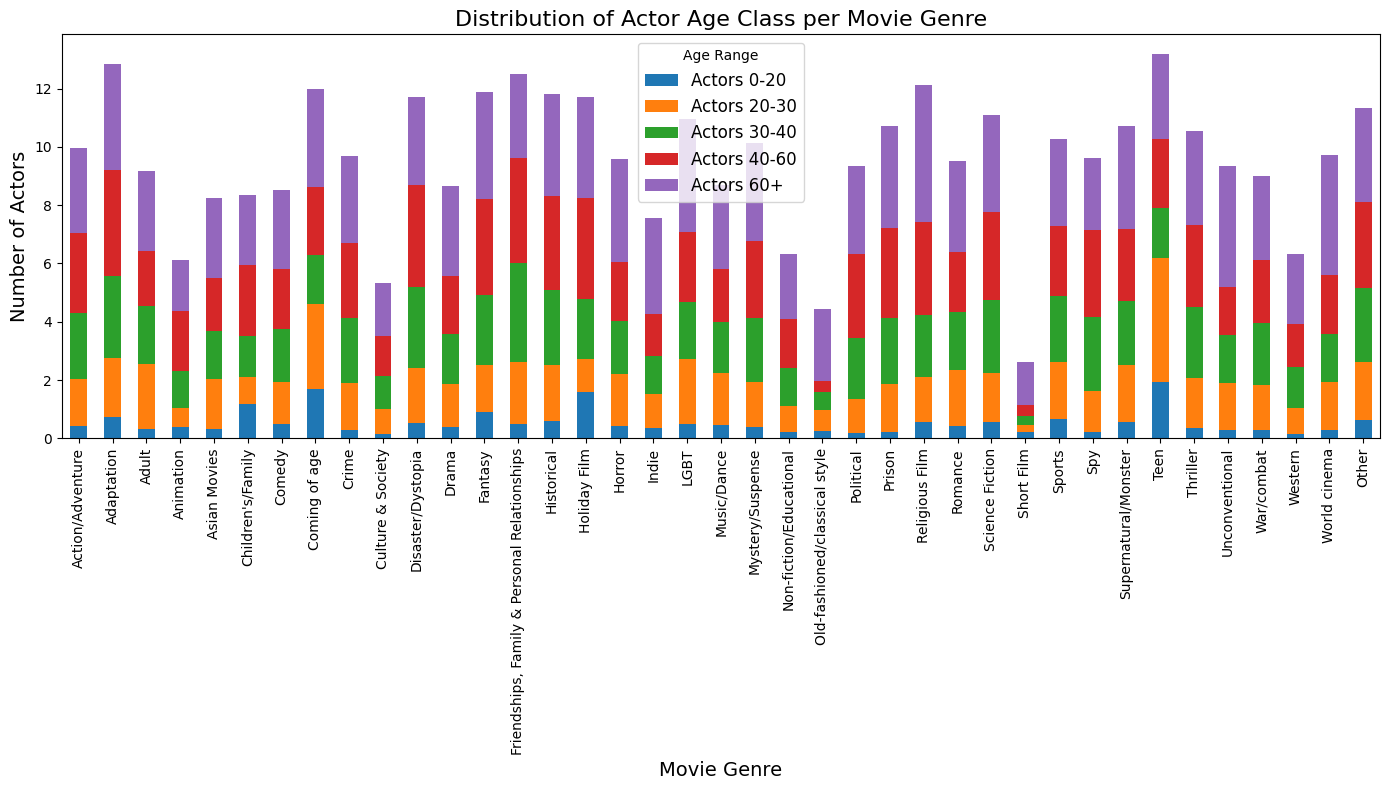

In [26]:
column_names = ['Actors 0-20', 'Actors 20-30', 'Actors 30-40', 'Actors 40-60', 'Actors 60+']
bar_per_genre(MOVIES, NEW_GENRE["categories"], column_names, "Distribution of Actor Age Class per Movie Genre",
                      "Movie Genre", "Number of Actors", "Age Range", stacked=True)

<span style="color:green"> Analysis: The genre of a movie seems to be slightly related to the age of actor staring in the movie. For instance, teen movies seems to have a bigger ratio of younger actors compared to other genres.</span>

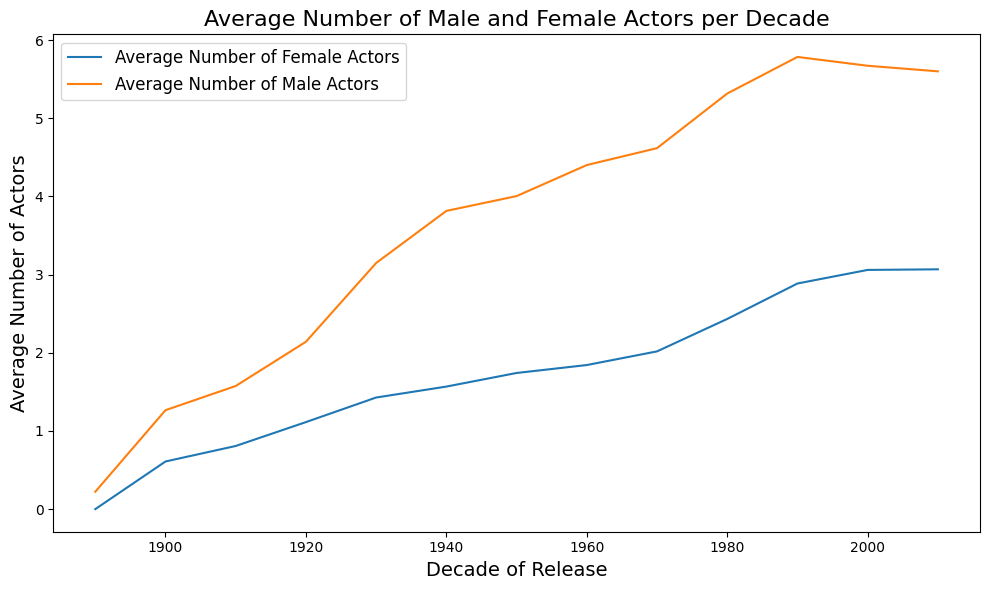

In [27]:
lineplot_per_genre_over_years(MOVIES, ['Female actor count', 'Male actor count'], "Average Number of Male and Female Actors per Decade",
                              "Decade of Release", "Average Number of Actors", ["Average Number of Female Actors", "Average Number of Male Actors"])


<span style="color:green"> Analysis: Both the number of male and female actors increase over the years.</span>.

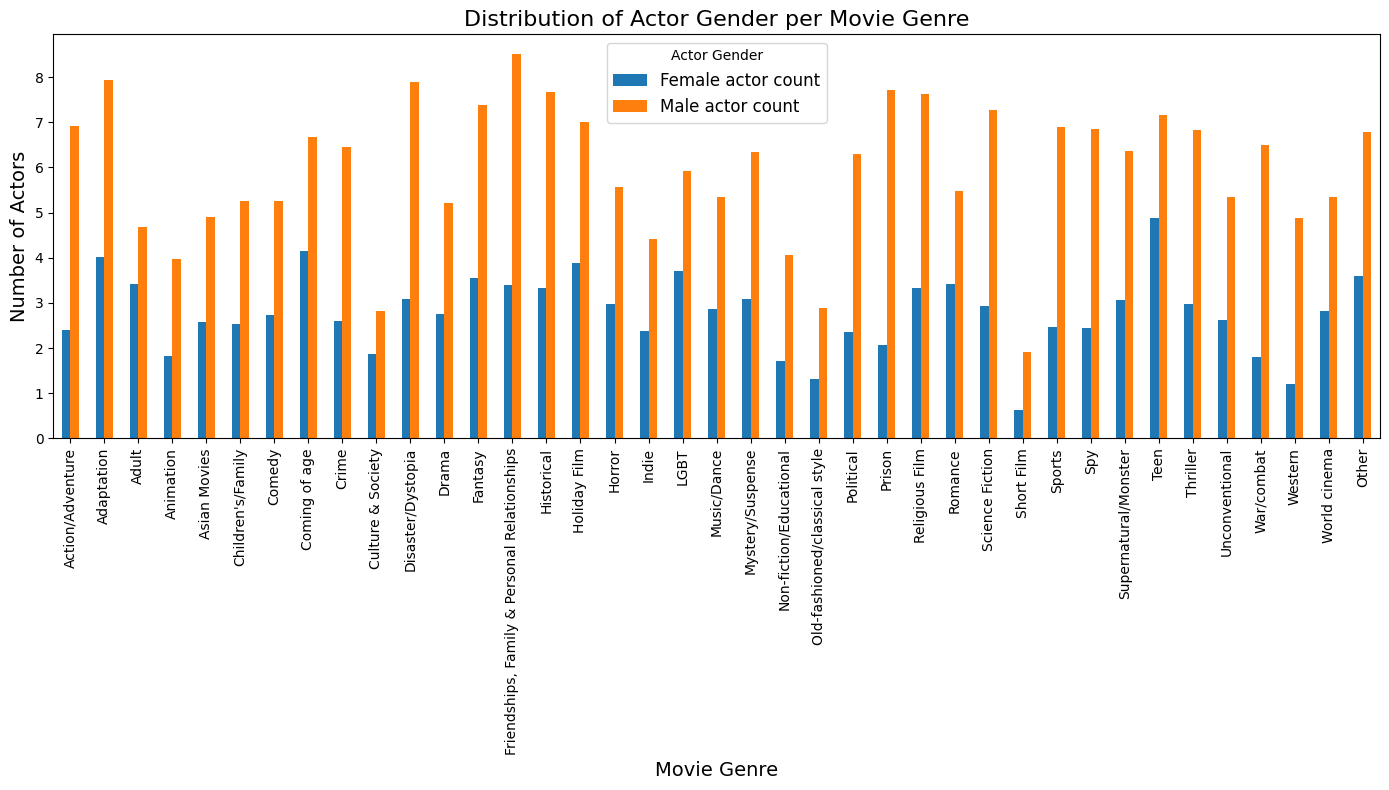

In [28]:
column_names = ['Female actor count', 'Male actor count']
bar_per_genre(MOVIES, NEW_GENRE["categories"], column_names, "Distribution of Actor Gender per Movie Genre",
                      "Movie Genre", "Number of Actors", "Actor Gender", stacked=False)

<span style="color:green"> Analysis: The number of male actors across genres is always higher. 
Though, in some genres, the difference is less for instance 'Cultures & Society'</span>.

### Genre runtime analysis
Bar plot of change in runtime over years for each genre


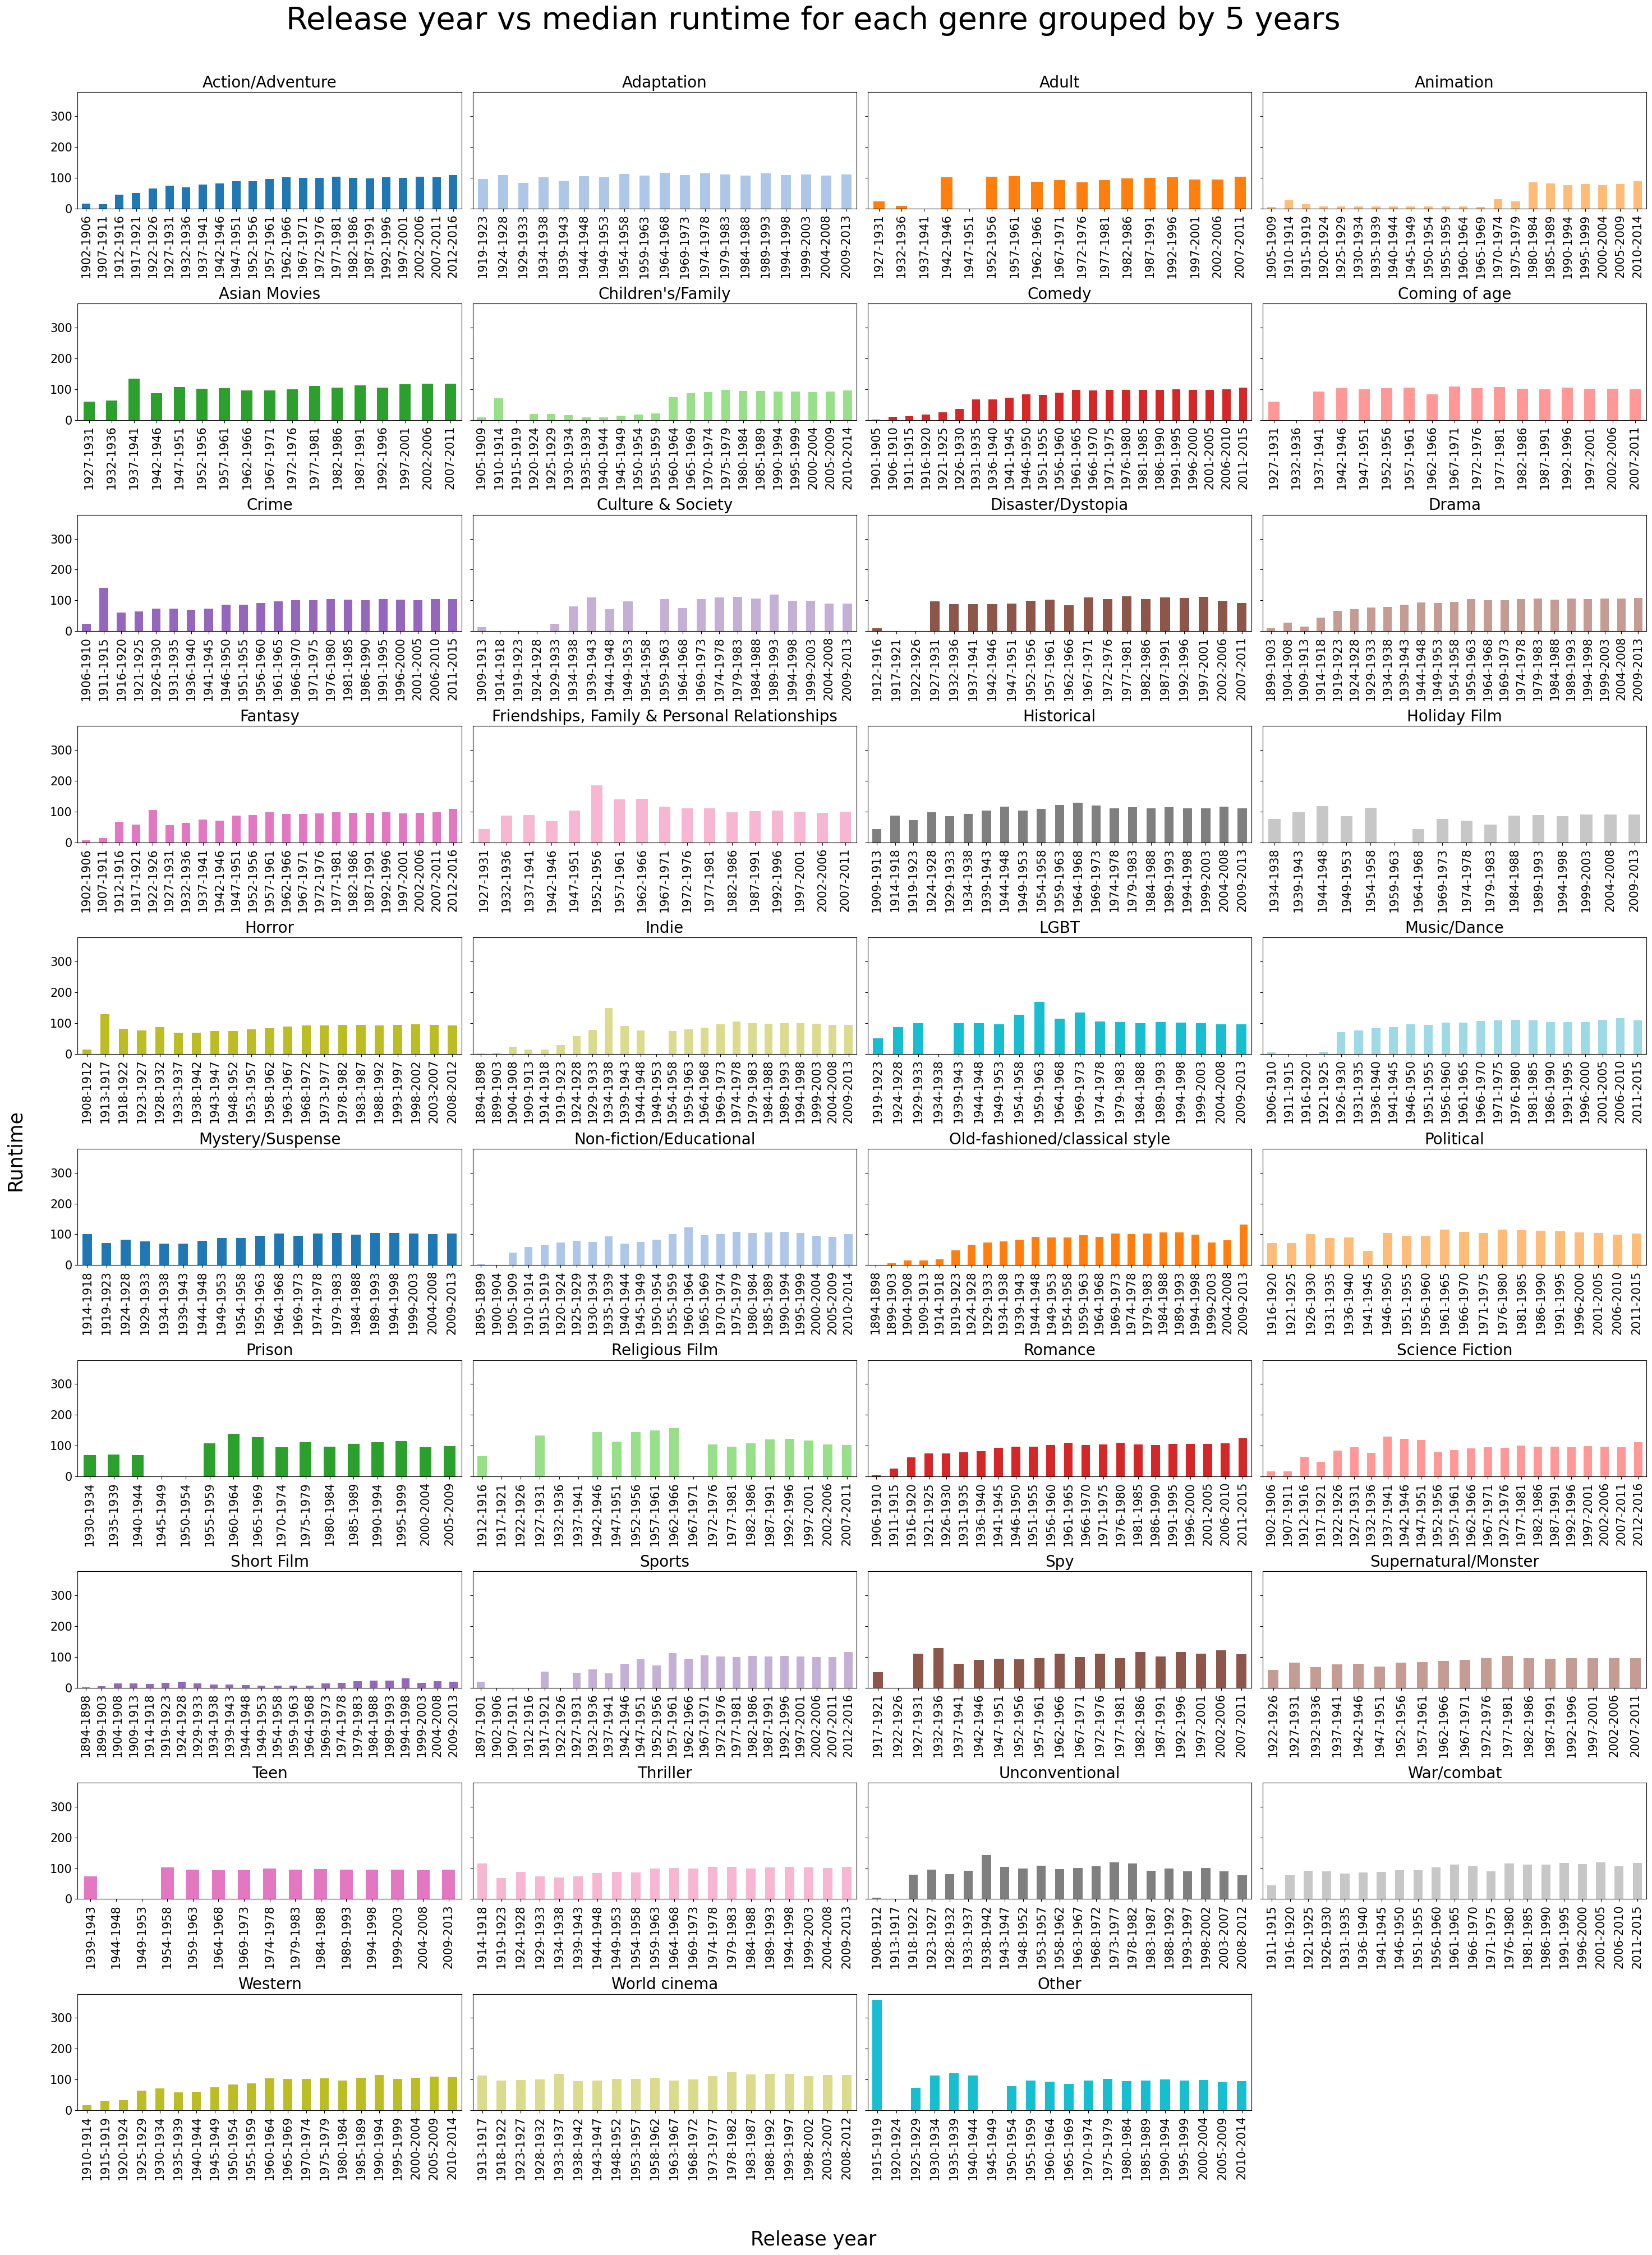

In [29]:
barplot_per_genre_over_years(MOVIES,  NEW_GENRE["categories"], 5, "runtime", 'Release year vs median runtime for each genre grouped by 5 years')

<span style="color:green"> Analysis: Some genres like Comedy, Action/Adventure and Western, show a trend of runtime increasing throughout the years.</span>

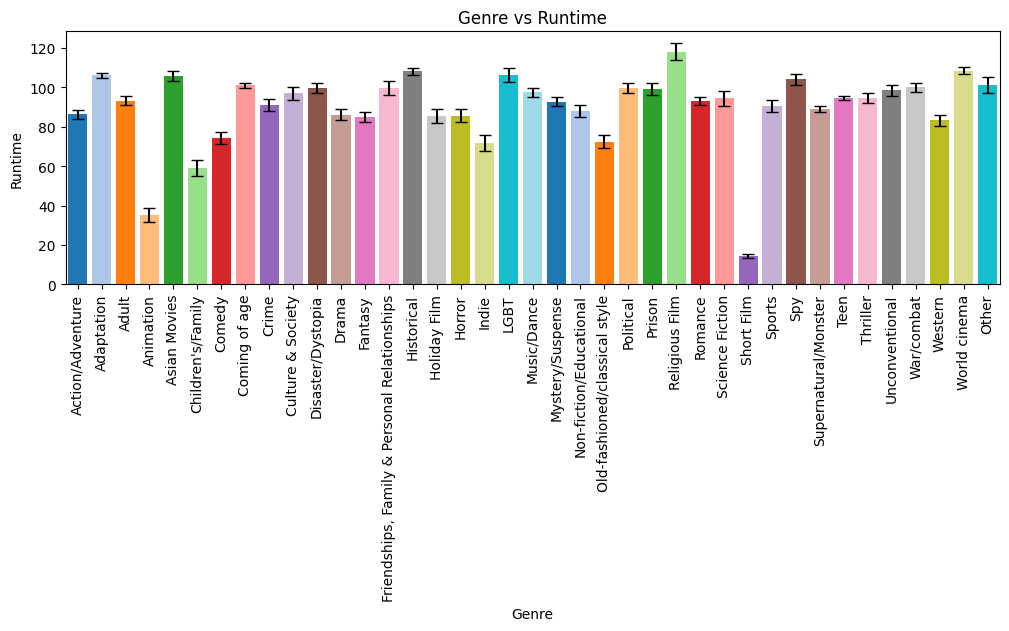

In [30]:
barplot_means_per_genre(MOVIES, NEW_GENRE["categories"], "runtime", "Genre vs Runtime", median=True, zeros=False)

<span style="color:green"> Analysis: most movies have similar runtime, except short movies, which like the name states, are much shorter. Animation and childrens movies, are also a bit shorter. This makes sense since they are made for children mostly.
</span>

### Genre revenue analysis

Genre vs mean of median revenue per year

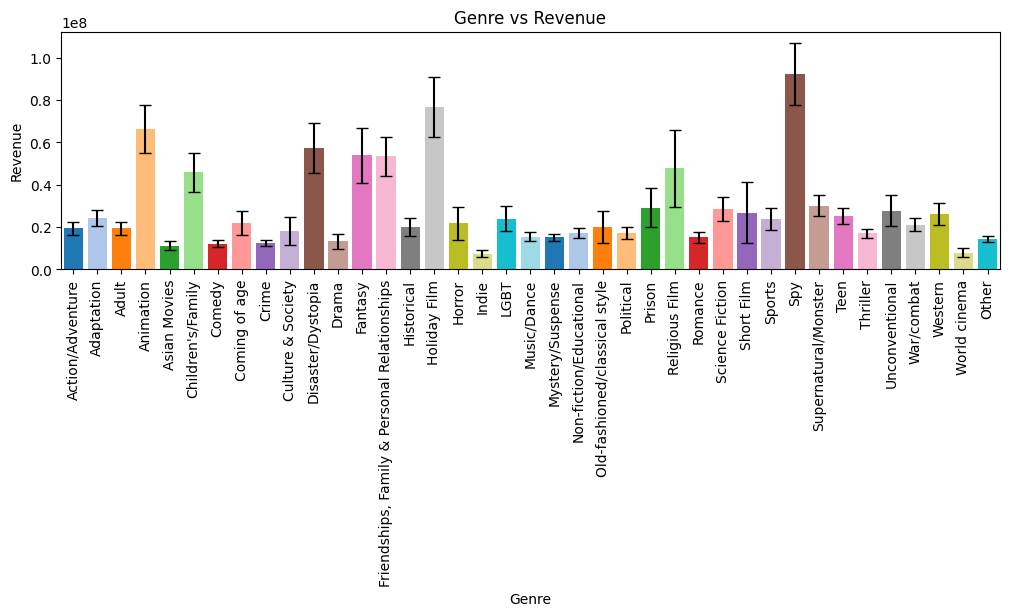

In [31]:
barplot_means_per_genre(MOVIES, NEW_GENRE["categories"], "revenue", "Genre vs Revenue", median=True, zeros=False)

<span style="color:green"> Analysis: There are some genres that stand out like spy and holiday movies, that earn more than others on average.
</span>.

### Genre plot_length analysis

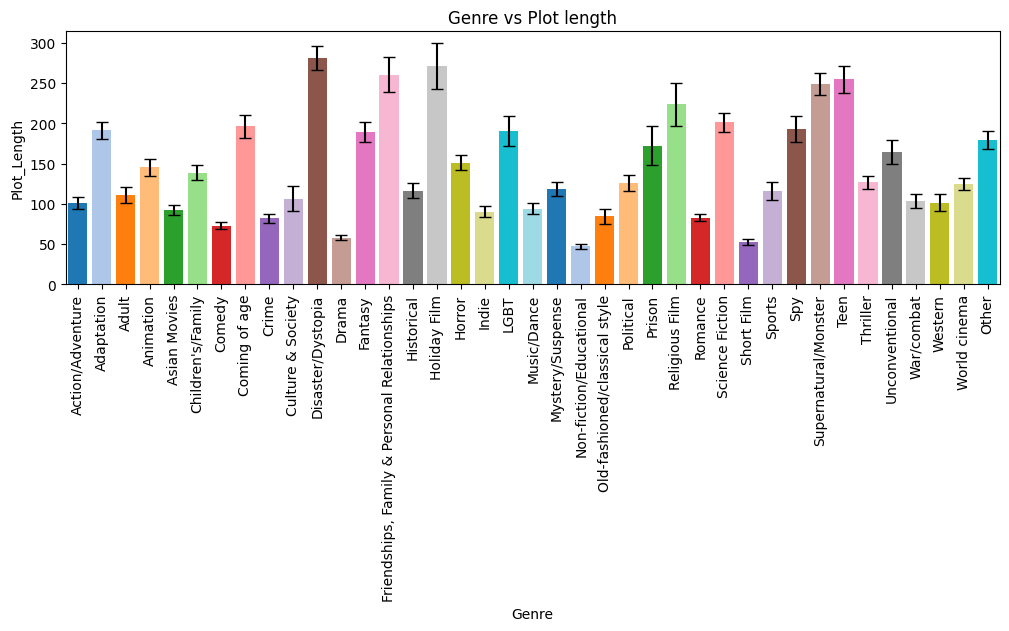

In [32]:
df_summaries = pd.read_csv("stemmed_movie_summaries.csv")
MOVIES['plot_length'] = df_summaries['text'].apply(lambda x: len(ast.literal_eval(x)))

barplot_means_per_genre(MOVIES, NEW_GENRE["categories"], "plot_length", "Genre vs Plot length", median=True, zeros=False)

<span style="color:green"> Analysis: Some genres have longer plot summaries than others. This could be due to the complexity of the stories told in those genres, that's to say, more complex stories could have longer summaries. However there could be external factors, like if the summaries were written by different people, that affect their length, so this genre vs plot-length analysis might not be very reliable.
</span>

### Budget vs revenue 

Plotting budget vs revenue for each genre

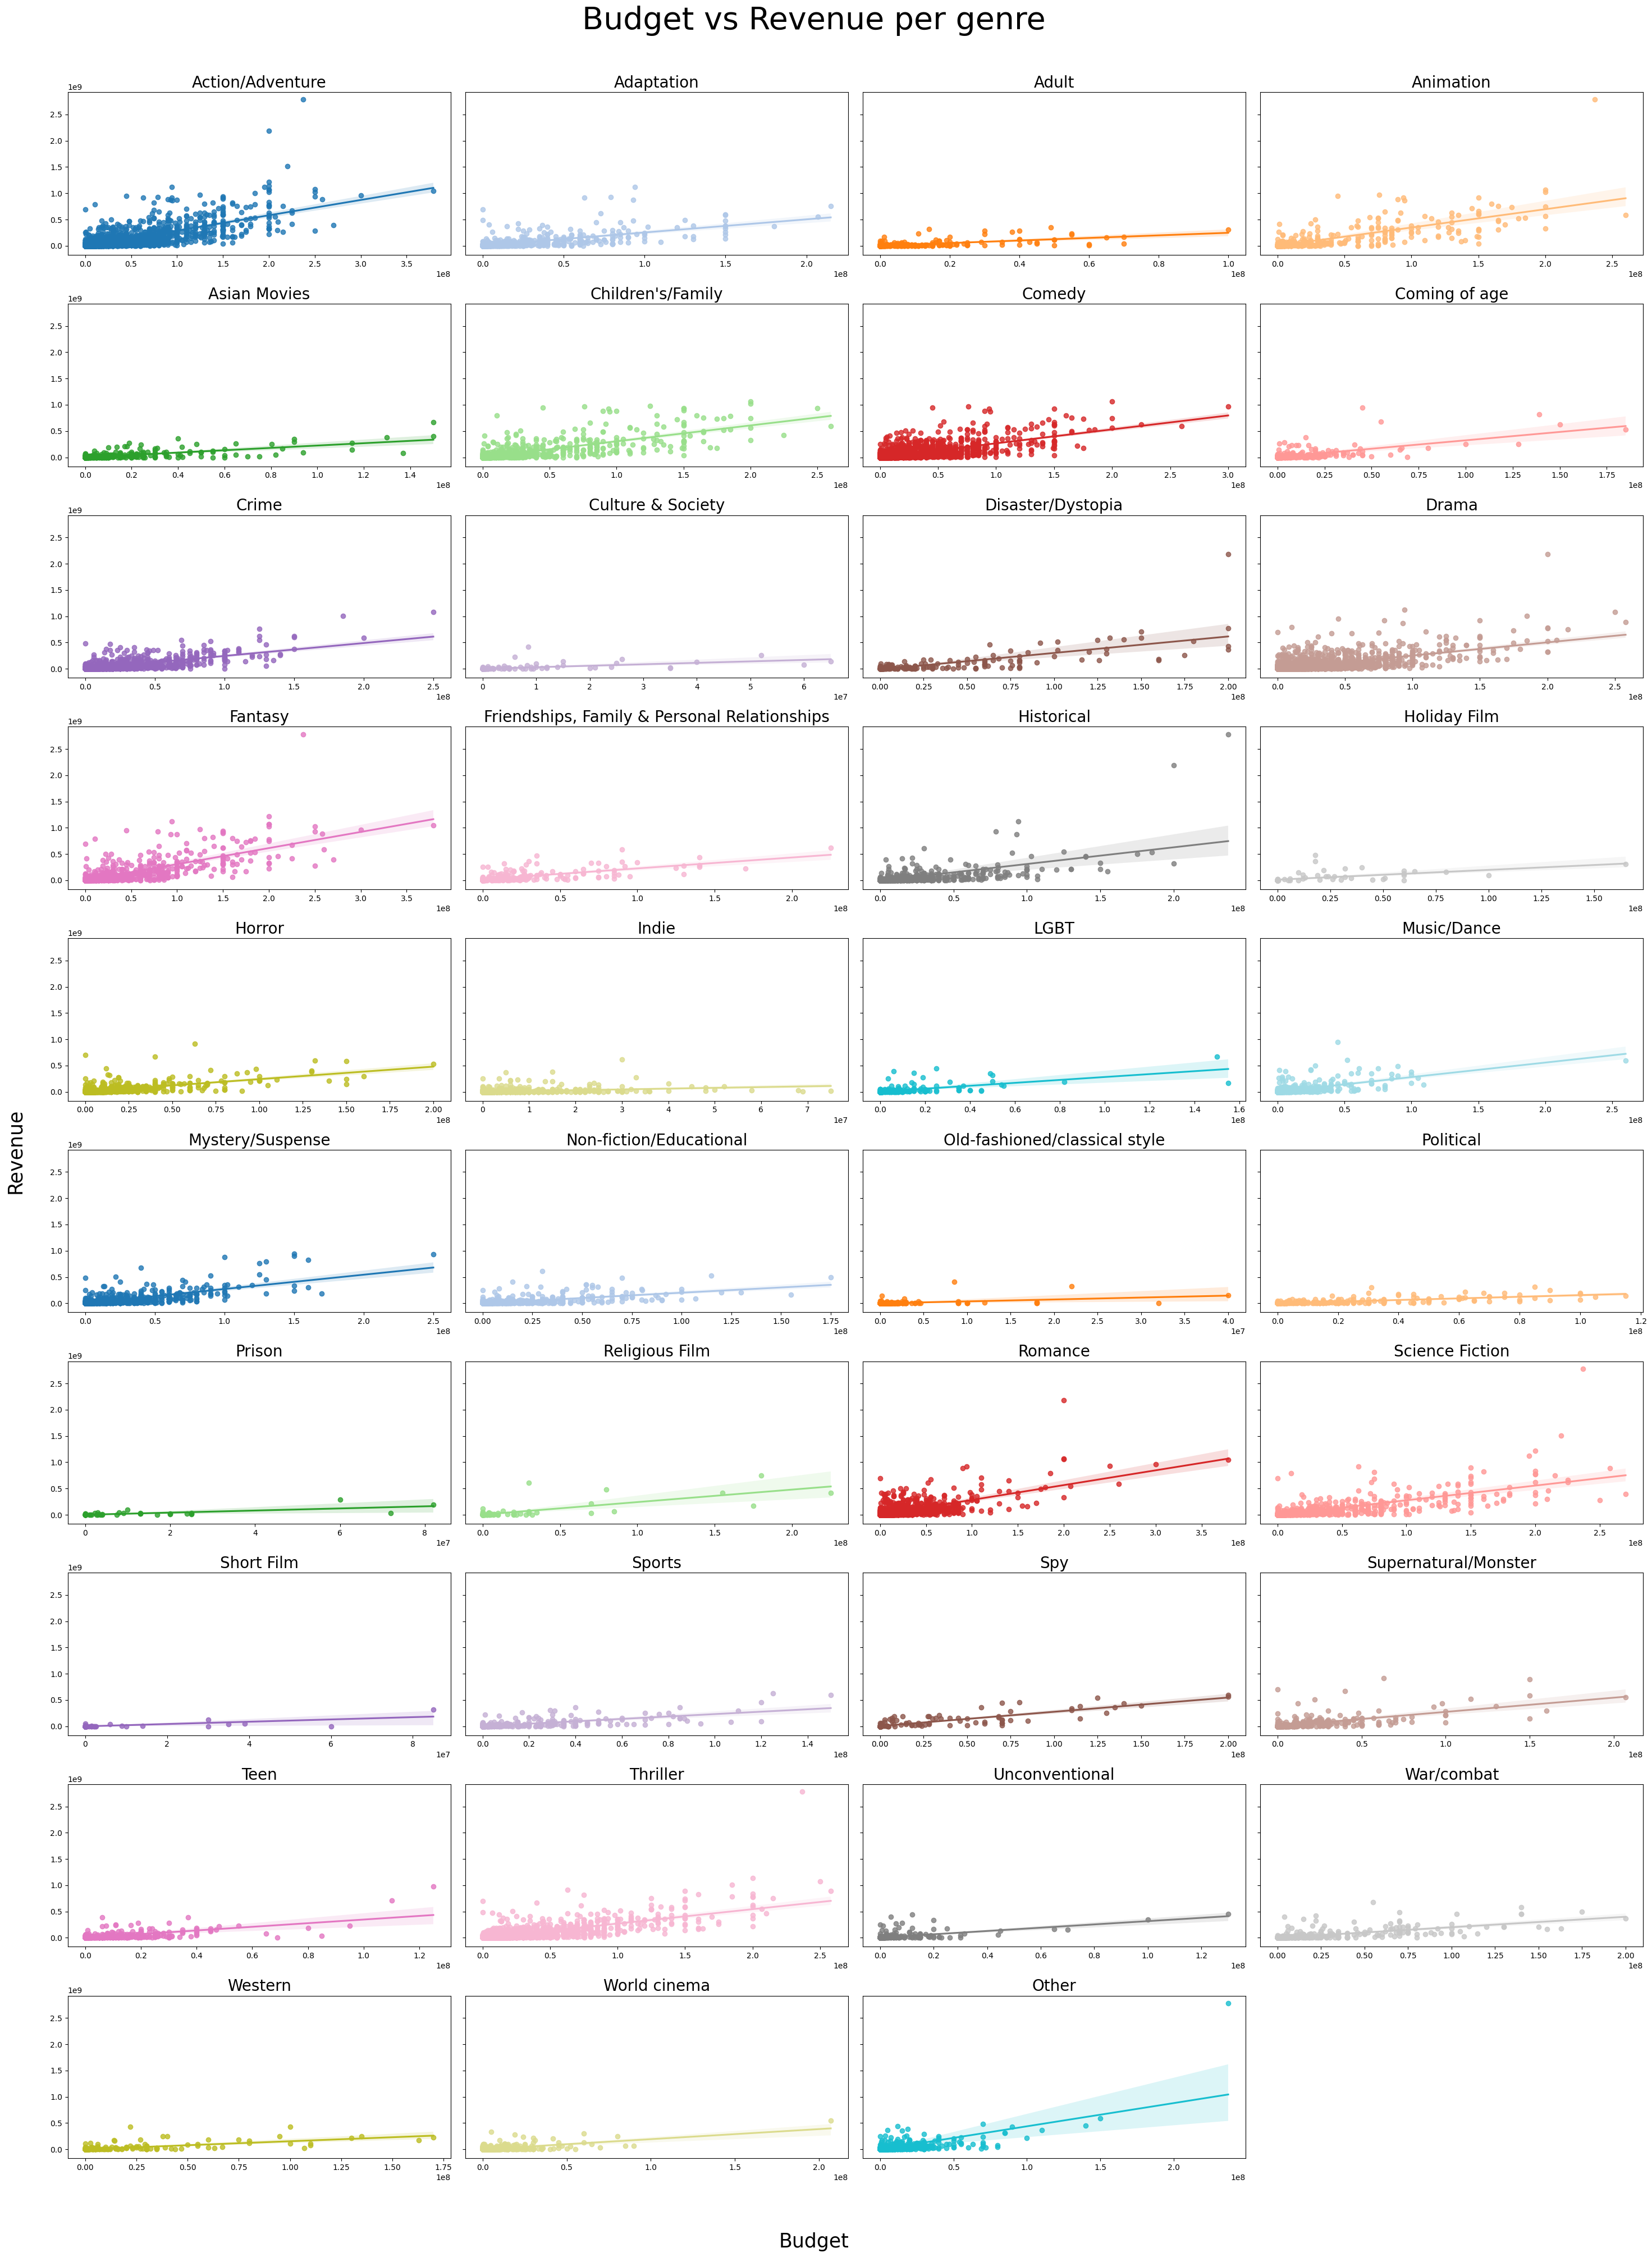

In [33]:
pd.options.mode.chained_assignment = None  # remove annoying warnigns
scatter_plot_per_genre(MOVIES, NEW_GENRE["categories"], 'budget', 'revenue', 'Budget vs Revenue per genre')

<span style="color:green"> Analysis: in general revenue increase with budget size. It could even be that big filmstudios that expects big revenue are more likely to be able to use more money. In the last genre (other), we see that the variance is a lot bigger, which could be explained by the fact that the category contains many different genres. 
</span>

### HEATMAP

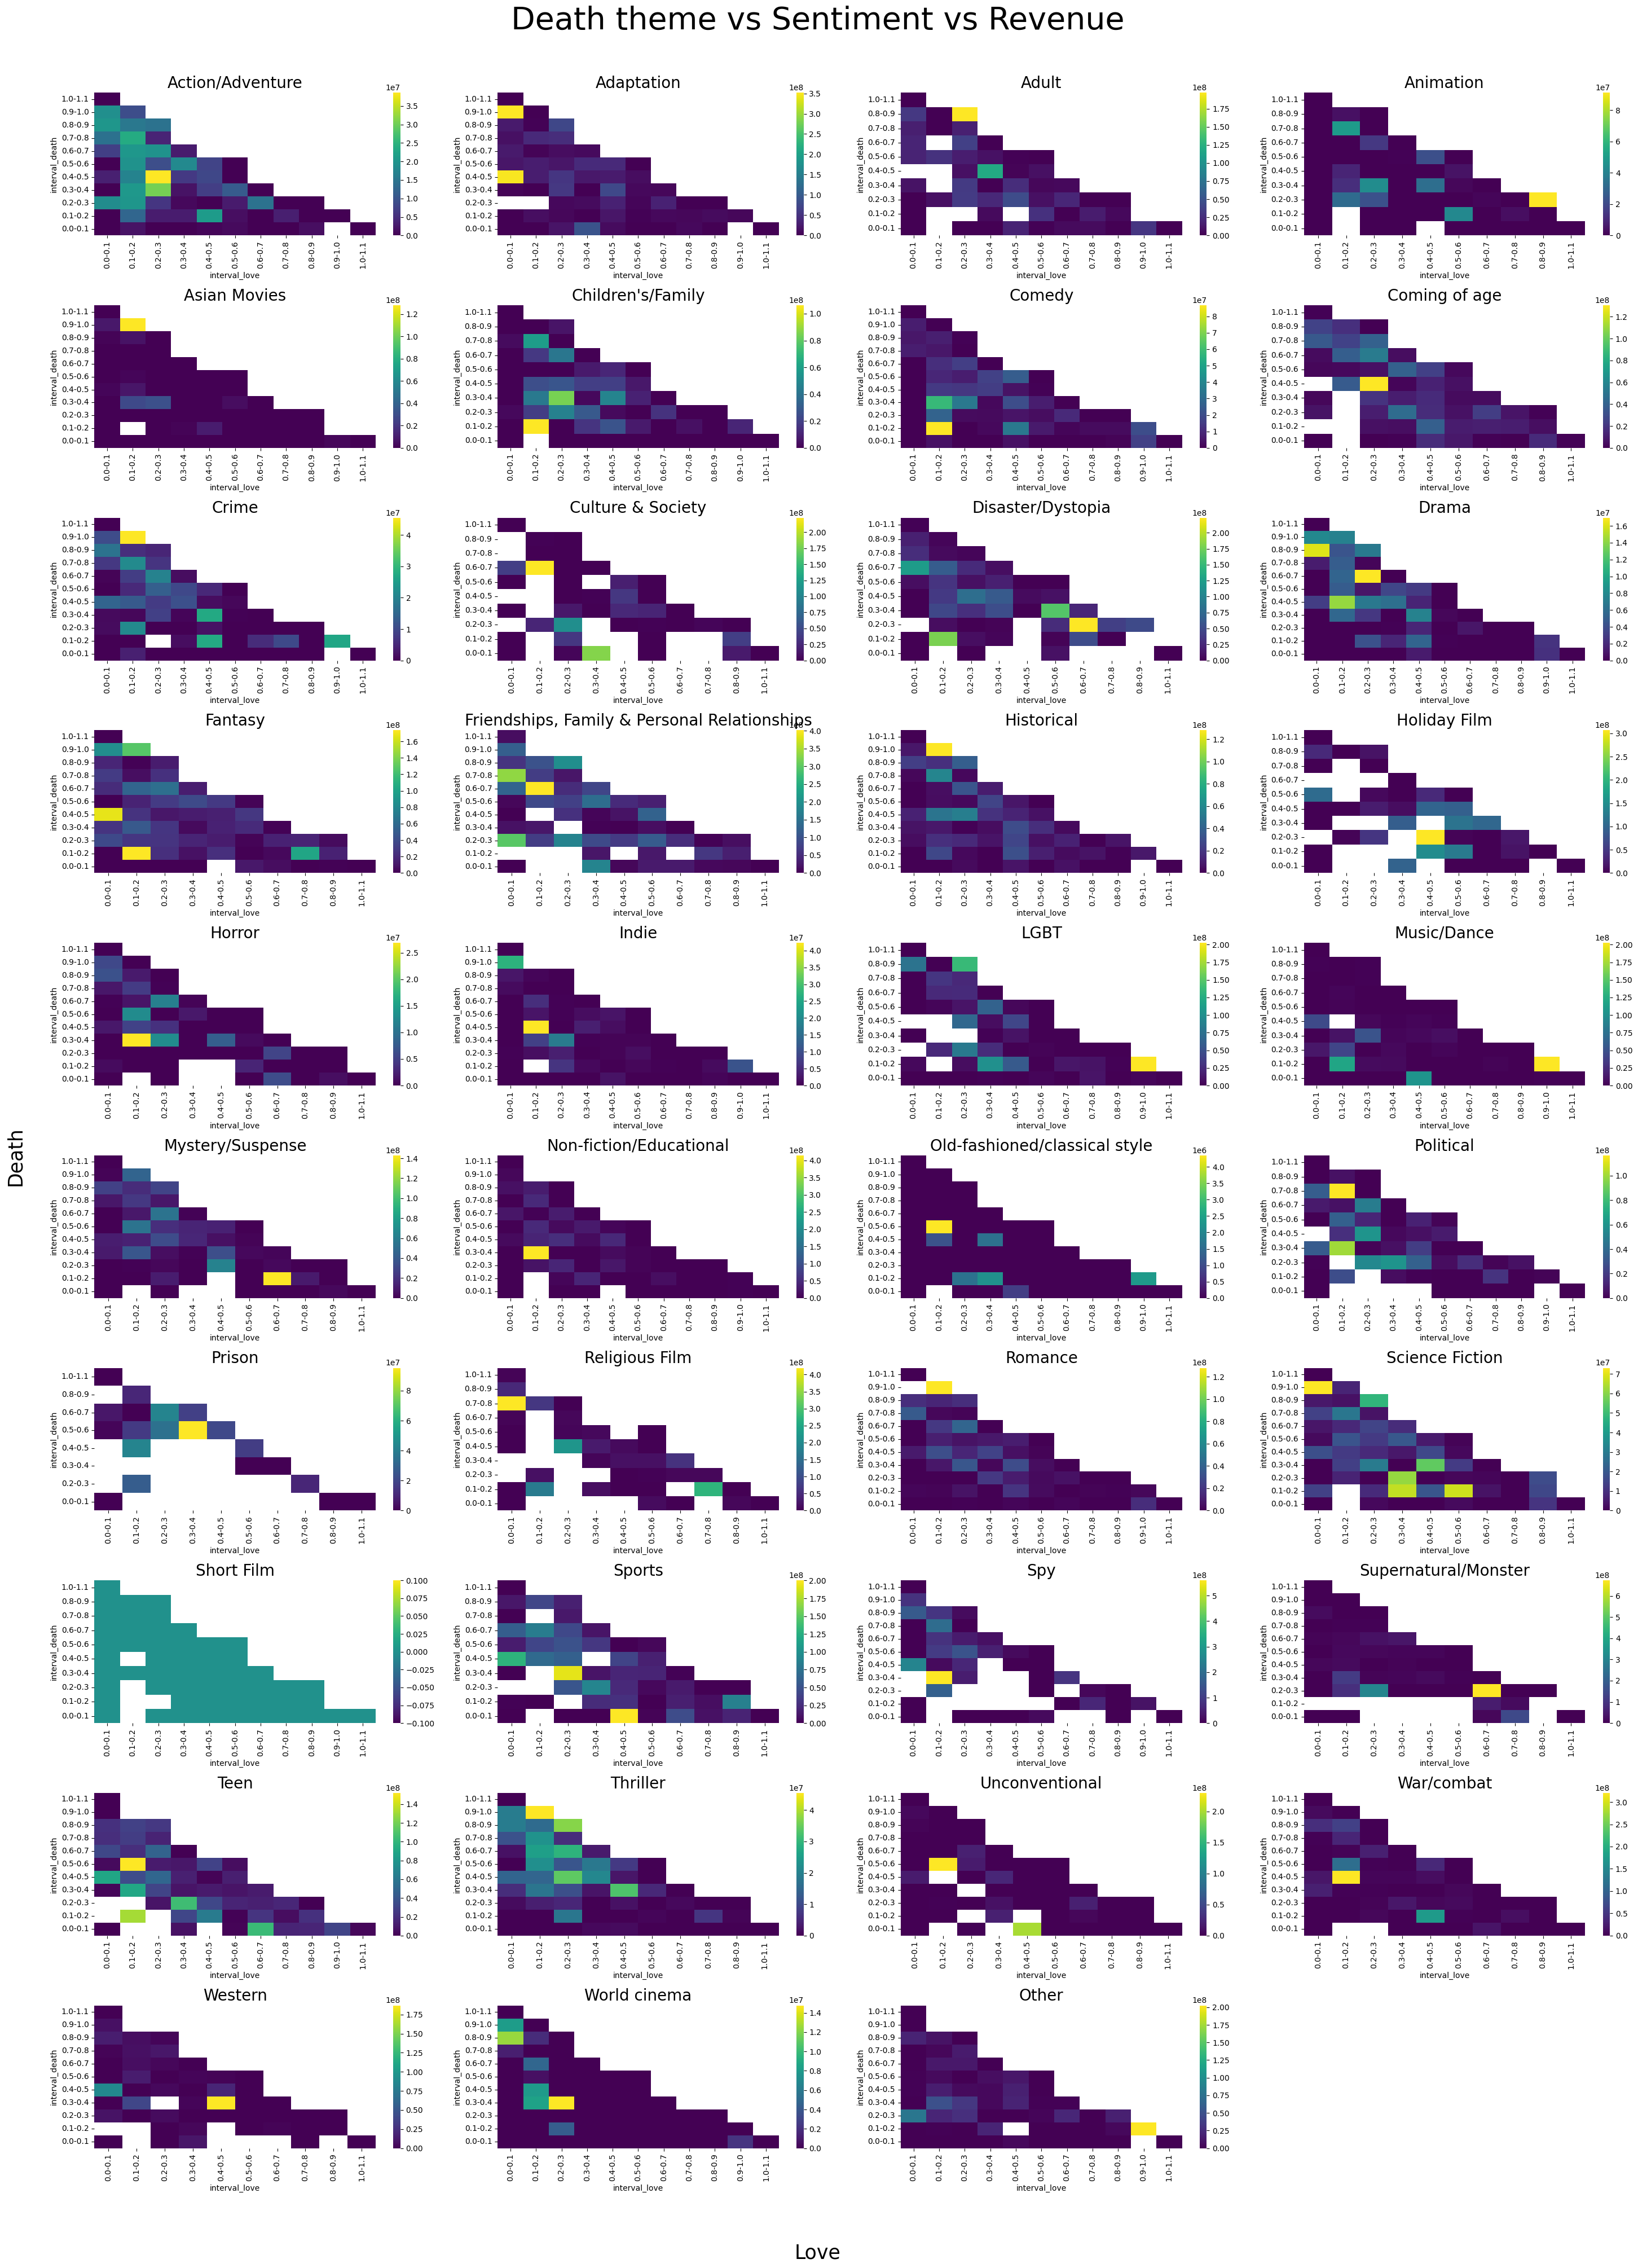

In [48]:
pd.options.mode.chained_assignment = None  # remove annoying warnings
heatmap_per_genre(MOVIES, NEW_GENRE["categories"], 'love', 'death', 'revenue', 0.1, 0.1, 'Death theme vs Love theme vs Revenue')

<span style="color:green"> Analysis: This might not be the best use of heatmaps as there are a lot of missing values (white cells) since the thematic values are normalized across all themes, hence the missing upper right half. However, we found it interesting how love nad death themes correlated to revenue. Generally, movies seem to get more revenue if there are more death and less love.
</span>

# MOVIE GENRE PREDICTOR MODEL

### Data splitting for crossvalidation

In [35]:
MOVIES.columns

Index(['wikipedia_movie_ID', 'name', 'release_date', 'revenue', 'runtime',
       'languages', 'countries', 'genres', 'release_year', 'vote_average',
       'vote_count', 'adult', 'budget', 'popularity', 'plot',
       'original_genres', 'new_genres', 'genre_hot', 'death', 'love',
       'tragedy', 'sentiment', 'Character Count', 'Female actor count',
       'Male actor count', 'N/A actor count', 'Actors 0-20', 'Actors 20-30',
       'Actors 30-40', 'Actors 40-60', 'Actors 60+', 'release_decade',
       'plot_length'],
      dtype='object')

In [36]:
training_columns = [
    "revenue", "runtime", "release_year",  "vote_average", "vote_count", "adult", "budget", "popularity", "sentiment",
    'death', 'love', 'tragedy', 'Character Count', 'Female actor count', 'Male actor count', 'N/A actor count', 
    'Actors 0-20', 'Actors 20-30', 'Actors 30-40', 'Actors 40-60', 'Actors 60+'
] 
target_column = ["genre_hot"]
training_set, training_target_set, testing_set, testing_target_set = train_and_test_split(MOVIES, training_columns, target_column, train_proportion =  SETTINGS["MODEL_SETTINGS"]["TEST_PROPORTION"],seed = SETTINGS["MODEL_SETTINGS"]["SEED"],)

### Model

In [37]:
feature_size = len(training_columns)
genre_size = len(NEW_GENRE["subgenres"])

model_factory = lambda: get_model(feature_size, genre_size, SETTINGS["MODEL_SETTINGS"]["LAYER_SIZE"])
model = model_factory()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device_cpu = torch.device("cpu")
model = model.to(device=device)

optimizer_kwargs = dict(
    lr=3e-4,
    weight_decay=1e-3,
)
optimizer = torch.optim.AdamW(model.parameters(), **optimizer_kwargs)

### Model training

We use stochastic training for better performance. The batch size is 10 by default.

In [38]:
batches_train, batches_test = get_training_batch(training_set, training_target_set)
# print(f"{batches_train = }")
# print(f"{batches_test = }")

trained_model, train_loss, train_acc, f_score_history, precision_history, recall_history = train_model(
    batches_train, batches_test, model, optimizer, SETTINGS["MODEL_SETTINGS"]["GENRE_THRESHOLD"], device
) 

Batch loss_float = 8.3704
Batch accuracy = 0.4462
Batch f_score = 0.1030
Batch precision = 0.0603
Batch recall = 0.5083
Batch loss_float = 3.0166
Batch accuracy = 0.9154
Batch f_score = 0.2400
Batch precision = 0.4200
Batch recall = 0.1900
Batch loss_float = 6.2671
Batch accuracy = 0.8949
Batch f_score = 0.0614
Batch precision = 0.0583
Batch recall = 0.0650
Batch loss_float = 6.7955
Batch accuracy = 0.8897
Batch f_score = 0.1400
Batch precision = 0.1138
Batch recall = 0.1983
Batch loss_float = 6.5340
Batch accuracy = 0.8923
Batch f_score = 0.0817
Batch precision = 0.0714
Batch recall = 0.1575
Batch loss_float = 5.2171
Batch accuracy = 0.9231
Batch f_score = 0.2361
Batch precision = 0.2400
Batch recall = 0.2367
Batch loss_float = 7.0126
Batch accuracy = 0.8949
Batch f_score = 0.1036
Batch precision = 0.1667
Batch recall = 0.0783
Batch loss_float = 4.4632
Batch accuracy = 0.9154
Batch f_score = 0.0000
Batch precision = 0.0000
Batch recall = 0.0000
Batch loss_float = 3.4548
Batch accuracy

### Training Plotting

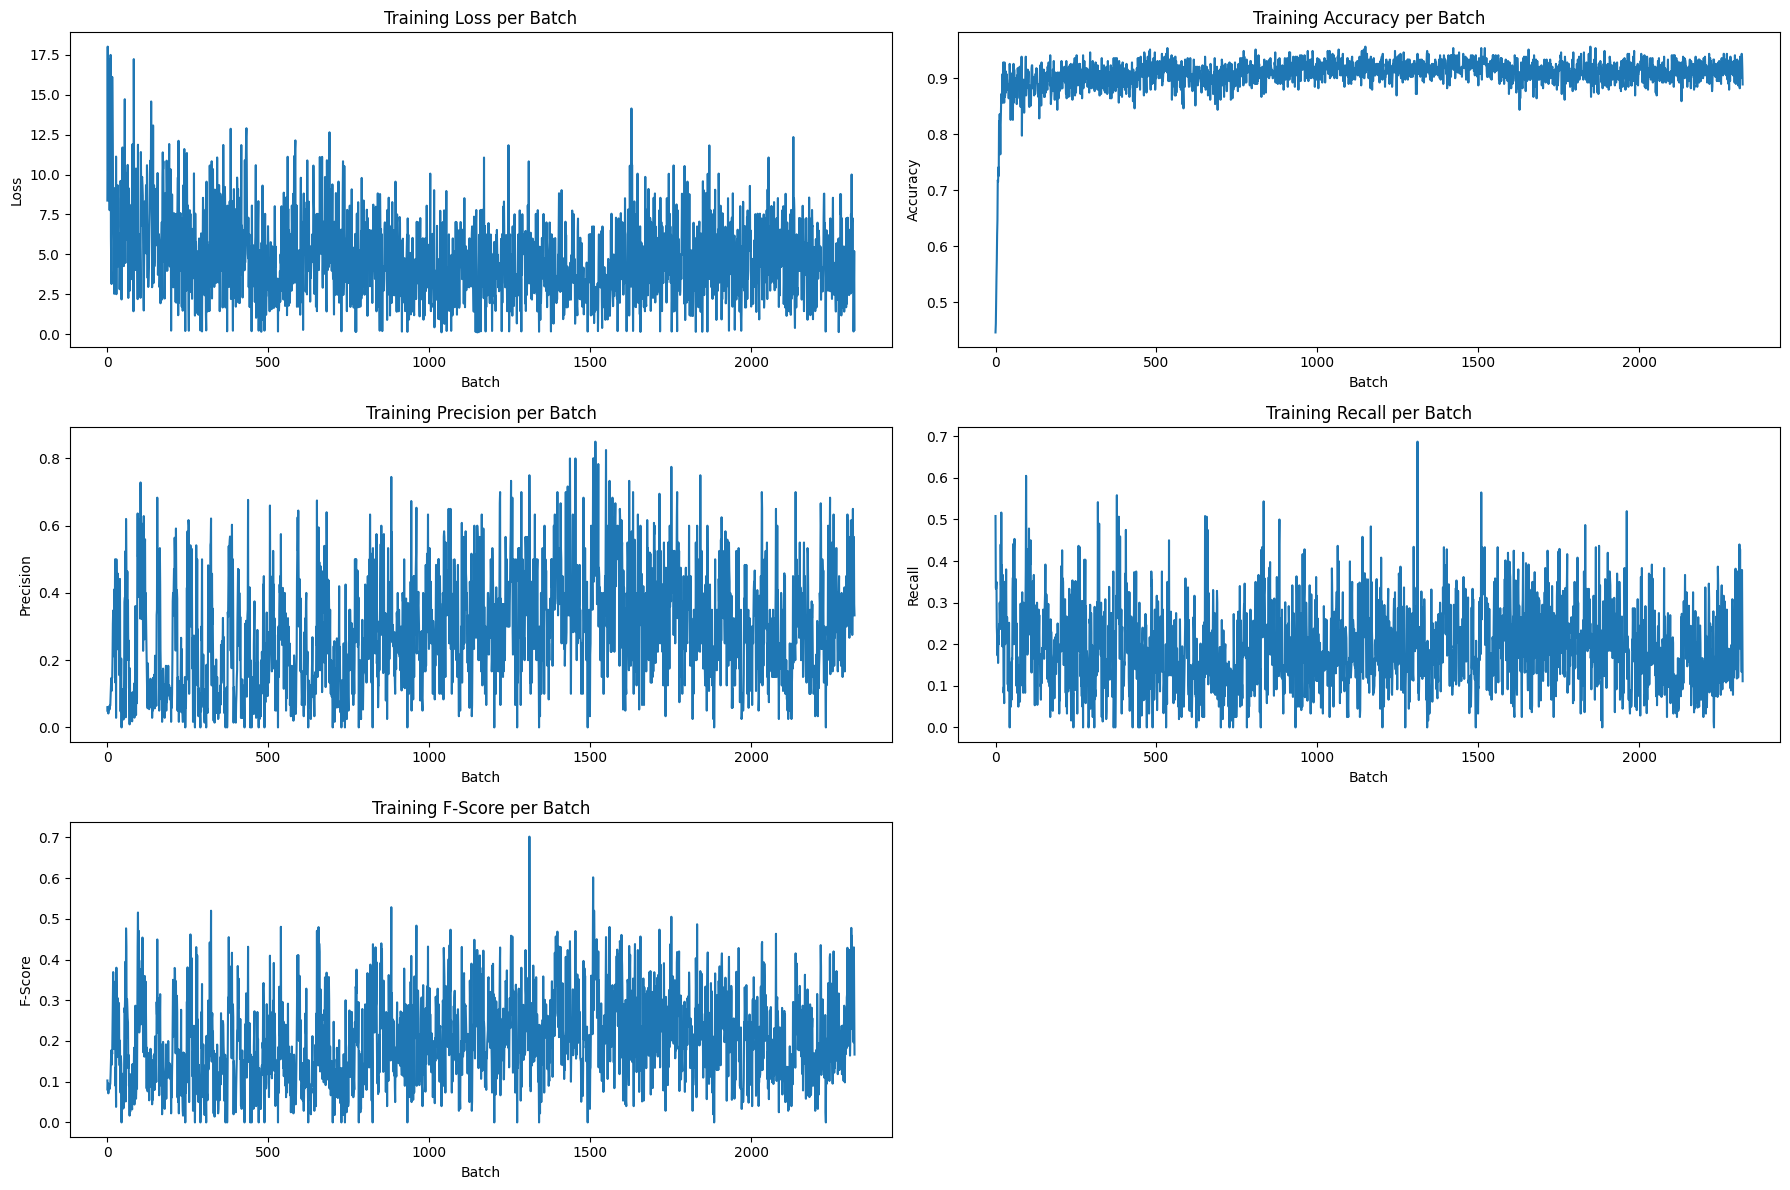

In [39]:
batch_indices = [i for i in range(len(batches_train))]

plt.figure(figsize=(18, 12)) 

plt.subplot(3, 2, 1)
plt.plot(batch_indices, train_loss)
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.title("Training Loss per Batch")

plt.subplot(3, 2, 2)
plt.plot(batch_indices, train_acc)
plt.xlabel("Batch")
plt.ylabel("Accuracy")
plt.title("Training Accuracy per Batch")

plt.subplot(3, 2, 3)
plt.plot(batch_indices, precision_history)
plt.xlabel("Batch")
plt.ylabel("Precision")
plt.title("Training Precision per Batch")

plt.subplot(3, 2, 4)
plt.plot(batch_indices, recall_history)
plt.xlabel("Batch")
plt.ylabel("Recall")
plt.title("Training Recall per Batch")

plt.subplot(3, 2, 5)
plt.plot(batch_indices, f_score_history)
plt.xlabel("Batch")
plt.ylabel("F-Score")
plt.title("Training F-Score per Batch")

plt.tight_layout()
plt.show()

In [40]:
del batches_train
del batches_test
del training_set
del training_target_set
del train_loss
del train_acc
del precision_history
del recall_history
del f_score_history
torch.cuda.empty_cache()

### Model testing

In [41]:
testing_set_t = torch.tensor(testing_set[training_columns].values.tolist(), dtype=torch.float32).to(device_cpu)
testing_target_set_t = torch.tensor(testing_target_set.values.tolist(), dtype=torch.float32).to(device_cpu)
trained_model = trained_model.to(device_cpu)

predictions = test_model(trained_model, testing_set_t, testing_target_set_t, SETTINGS["MODEL_SETTINGS"]["GENRE_THRESHOLD"])

genre_labels = NEW_GENRE["categories"]
predicted_genre = []

for movie_prediction in predictions:
    genres = [genre_labels[i] for i, is_genre in enumerate(movie_prediction) if is_genre == 1]
    predicted_genre.append(genres)

predictins_output = pd.DataFrame({
    'wikipedia_movie_ID': testing_set["wikipedia_movie_ID"],
    'name': testing_set["name"],
    'original_genres': testing_set["new_genres"],
    'predicted_genres': predicted_genre,
})


predictins_output.to_csv("movies_predicted_genre.csv", index = False)


Testing accuracy = 205839.1485
Testing f_score = 0.0142
Testing precision = 0.0436
Testing recall = 0.0115
